In [2]:
import os
import numpy as np
import pandas as pd
import cv2
import itertools
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import TensorBoard, ModelCheckpoint, LambdaCallback
from keras import backend as K
from keras.utils import Sequence
from keras_tqdm import TQDMNotebookCallback

import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
from IPython.display import clear_output

from classes import IMAGENET2012_CLASSES

# Check we can get images from the dataset.
TRAIN_DIR = "../../../Kaggle/imagenet-mini/train"
VAL_DIR = "../../../Kaggle/imagenet-mini/val"
TEST_DIR = "../../../Kaggle/pexels"

def load_images(path):
    i = 0
    images = []
    for root, dirs, files in os.walk(path):
        for file in files:
            if i > 5: return np.array(images)
            if file.endswith(".JPEG"):
                print(file)
                image = cv2.imread(os.path.join(root, file))
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                images.append(image)
                i += 1
    
    return np.array(images)

train_images = load_images(TRAIN_DIR)
assert len(IMAGENET2012_CLASSES) == 1000

Using TensorFlow backend.


n01440764_10043.JPEG
n01440764_10470.JPEG
n01440764_10744.JPEG
n01440764_10845.JPEG
n01440764_11170.JPEG
n01440764_12021.JPEG


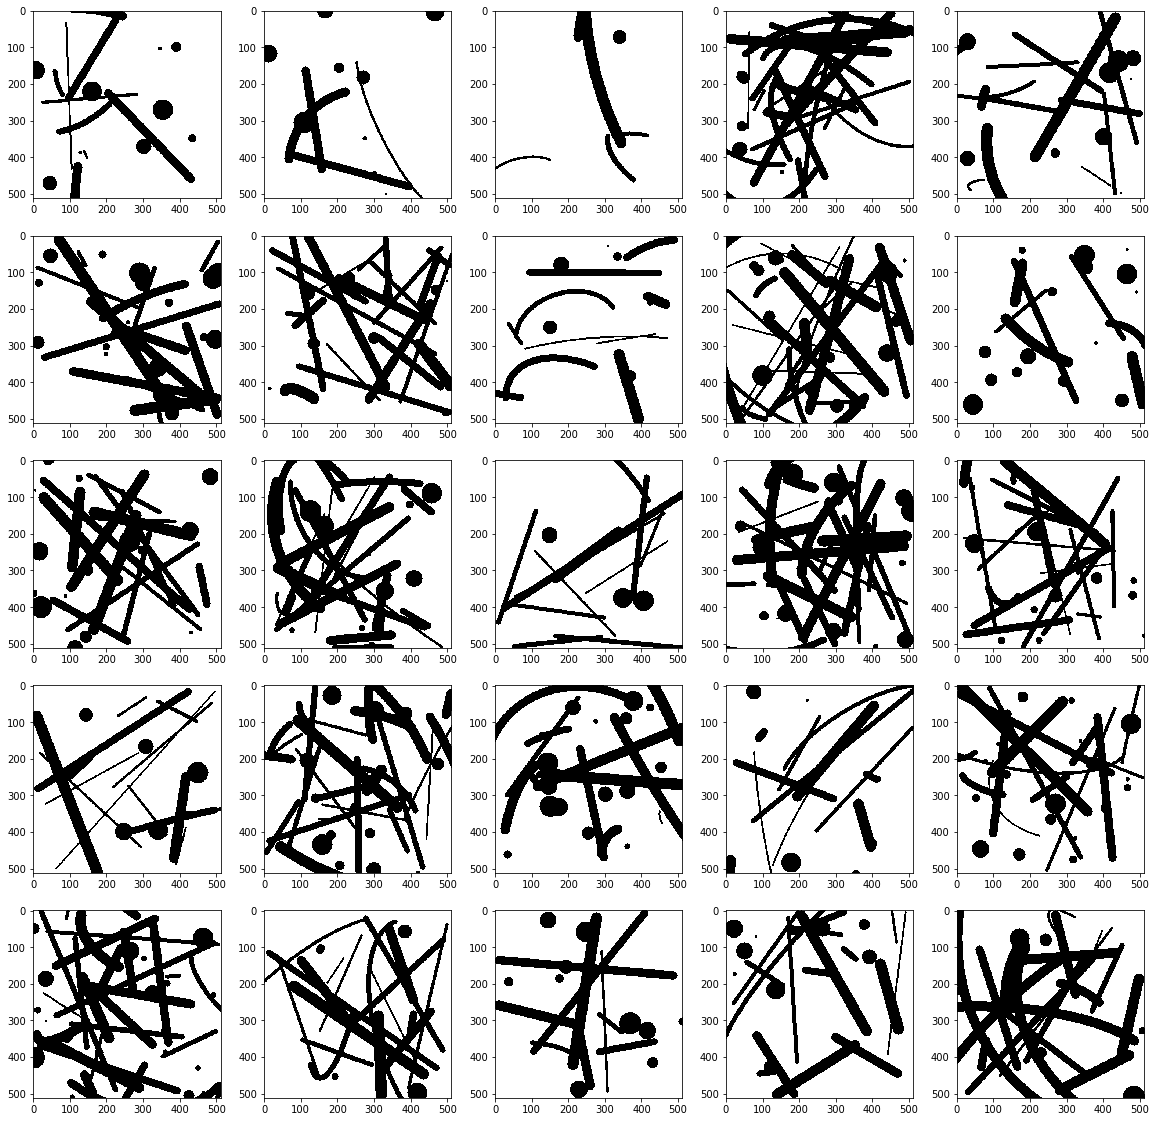

In [3]:
# Mask image training and test dataset: https://nv-adlr.github.io/publication/partialconv-inpainting
from utils import MaskGenerator
%matplotlib inline
# ??MaskGenerator._generate_mask
# Instantiate mask generator
mask_generator = MaskGenerator(512, 512, 3, rand_seed=42)

# Plot the results
_, axes = plt.subplots(5, 5, figsize=(20, 20))
axes = list(itertools.chain.from_iterable(axes))

for i in range(len(axes)):
    
    # Generate image
    img = mask_generator.sample()
    
    # Plot image on axis
    axes[i].imshow(img*255)

Shape of image is: (500, 418, 3)


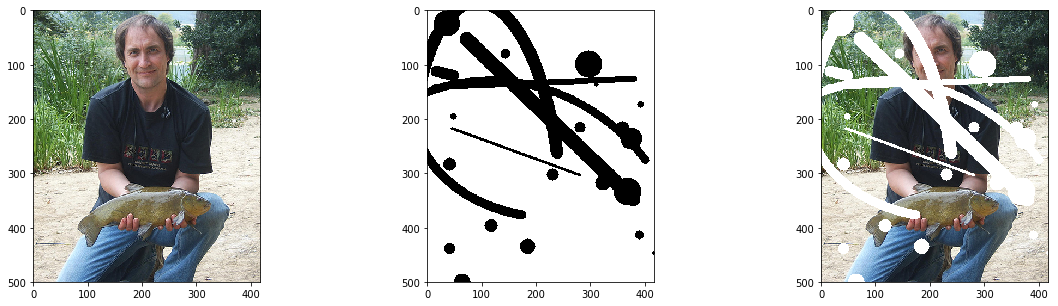

In [4]:
# Implementing the Partial Convolution Layer
from copy import deepcopy

from keras.layers import Input, Dense, ZeroPadding2D
from keras.models import Model

from layers import PConv2D
from utils import MaskGenerator

%matplotlib inline
# %load_ext autoreload
# %autoreload 2
# Load image
img = cv2.imread(TRAIN_DIR + '/n01440764/n01440764_1775.JPEG')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
shape = img.shape
print(f"Shape of image is: {shape}")

# Instantiate mask generator
mask_generator = MaskGenerator(shape[0], shape[1], 3, rand_seed=42)

# Load mask
mask = mask_generator.sample()

# Image + mask
masked_img = deepcopy(img)
masked_img[mask==0] = 255

# Show side by side
_, axes = plt.subplots(1, 3, figsize=(20, 5))
axes[0].imshow(img)
axes[1].imshow(mask*255)
axes[2].imshow(masked_img)
plt.show()

In [5]:
## Implement model
# Input images and masks
input_img = Input(shape=(shape[0], shape[1], shape[2],))
input_mask = Input(shape=(shape[0], shape[1], shape[2],))
output_img, output_mask1 = PConv2D(8, kernel_size=(7,7), strides=(2,2))([input_img, input_mask])
output_img, output_mask2 = PConv2D(16, kernel_size=(5,5), strides=(2,2))([output_img, output_mask1])
output_img, output_mask3 = PConv2D(32, kernel_size=(5,5), strides=(2,2))([output_img, output_mask2])
output_img, output_mask4 = PConv2D(64, kernel_size=(3,3), strides=(2,2))([output_img, output_mask3])
output_img, output_mask5 = PConv2D(64, kernel_size=(3,3), strides=(2,2))([output_img, output_mask4])
output_img, output_mask6 = PConv2D(64, kernel_size=(3,3), strides=(2,2))([output_img, output_mask5])
output_img, output_mask7 = PConv2D(64, kernel_size=(3,3), strides=(2,2))([output_img, output_mask6])
output_img, output_mask8 = PConv2D(64, kernel_size=(3,3), strides=(2,2))([output_img, output_mask7])

# Create model
model = Model(
    inputs=[input_img, input_mask], 
    outputs=[
        output_img, output_mask1, output_mask2, 
        output_mask3, output_mask4, output_mask5,
        output_mask6, output_mask7, output_mask8
    ])
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

# Show summary of the model
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 500, 418, 3)  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 500, 418, 3)  0                                            
__________________________________________________________________________________________________
p_conv2d_1 (PConv2D)            [(None, 250, 209, 8) 1184        input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
p_conv2d_2 (PConv2D)            [(None, 125, 105, 16 3216        p_conv2d_1[0][0]                 
          

In [6]:
# check mask layer update
formatted_img = np.expand_dims(masked_img, 0) / 255
formatted_mask = np.expand_dims(mask, 0)
print(f"Original Mask Shape: {formatted_mask.shape} - Max value in mask: {np.max(formatted_mask)}")

output_img, o1, o2, o3, o4, o5, o6, o7, o8 = model.predict([formatted_img, formatted_mask])

Original Mask Shape: (1, 500, 418, 3) - Max value in mask: 1


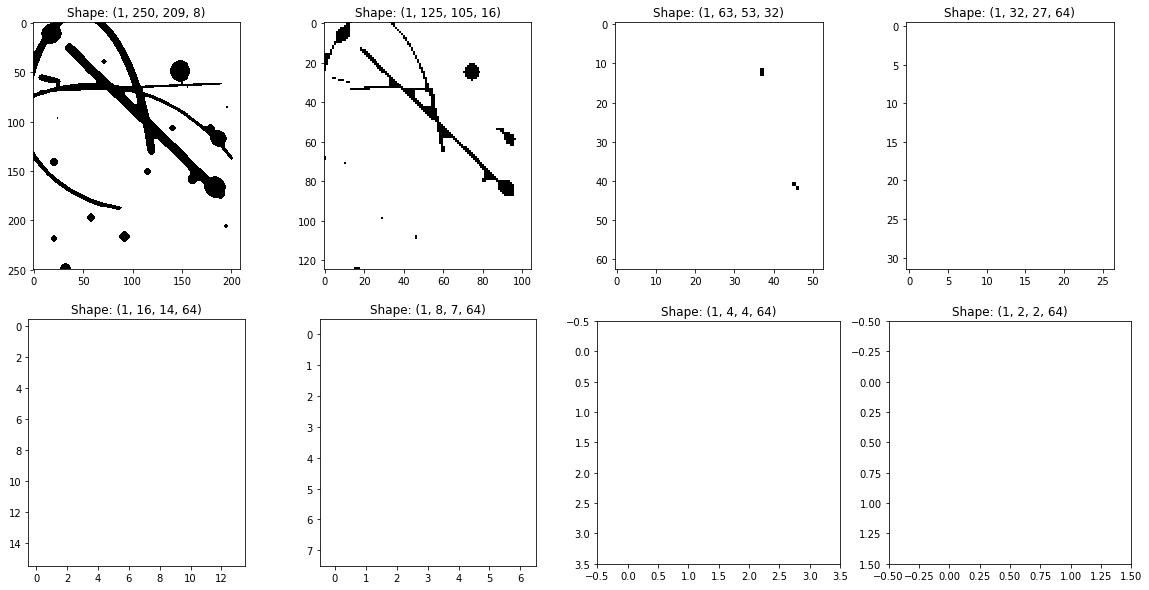

In [7]:
_, axes = plt.subplots(2, 4, figsize=(20, 10))
axes[0][0].imshow(o1[0, :,:, 0], cmap = 'gray', vmin=0, vmax=1)
axes[0][1].imshow(o2[0, :,:, 0], cmap = 'gray', vmin=0, vmax=1)
axes[0][2].imshow(o3[0, :,:, 0], cmap = 'gray', vmin=0, vmax=1)
axes[0][3].imshow(o4[0, :,:, 0], cmap = 'gray', vmin=0, vmax=1)
axes[1][0].imshow(o5[0, :,:, 0], cmap = 'gray', vmin=0, vmax=1)
axes[1][1].imshow(o6[0, :,:, 0], cmap = 'gray', vmin=0, vmax=1)
axes[1][2].imshow(o7[0, :,:, 0], cmap = 'gray', vmin=0, vmax=1)
axes[1][3].imshow(o8[0, :,:, 0], cmap = 'gray', vmin=0, vmax=1)
axes[0][0].set_title(f"Shape: {o1.shape}")
axes[0][1].set_title(f"Shape: {o2.shape}")
axes[0][2].set_title(f"Shape: {o3.shape}")
axes[0][3].set_title(f"Shape: {o4.shape}")
axes[1][0].set_title(f"Shape: {o5.shape}")
axes[1][1].set_title(f"Shape: {o6.shape}")
axes[1][2].set_title(f"Shape: {o7.shape}")
axes[1][3].set_title(f"Shape: {o8.shape}")
plt.show()

In [8]:
#******* Implementing the U-Net Architecture
import os
import gc
import copy

import numpy as np
from PIL import Image

from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import TensorBoard, ModelCheckpoint, LambdaCallback

import matplotlib
import matplotlib.pyplot as plt

from utils import MaskGenerator
from model import PConvUnet

# Settings
BATCH_SIZE = 4

# Imagenet Rescaling
MEAN = np.array([0.485, 0.456, 0.406])
STD = np.array([0.229, 0.224, 0.225])
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [9]:
# check the architecture of the network.
PConvUnet().summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs_img (InputLayer)         (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
inputs_mask (InputLayer)        (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
p_conv2d_9 (PConv2D)            [(None, 256, 256, 64 9472        inputs_img[0][0]                 
                                                                 inputs_mask[0][0]                
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 256, 256, 64) 0           p_conv2d_9[0][0]                 
__________

concatenate_3 (Concatenate)     (None, 8, 8, 1024)   0           activation_6[0][0]               
                                                                 up_sampling2d_3[0][0]            
__________________________________________________________________________________________________
concatenate_4 (Concatenate)     (None, 8, 8, 1024)   0           p_conv2d_14[0][1]                
                                                                 up_sampling2d_4[0][0]            
__________________________________________________________________________________________________
p_conv2d_18 (PConv2D)           [(None, 8, 8, 512),  4719104     concatenate_3[0][0]              
                                                                 concatenate_4[0][0]              
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 8, 8, 512)    2048        p_conv2d_18[0][0]                
__________

__________________________________________________________________________________________________
up_sampling2d_14 (UpSampling2D) (None, 256, 256, 128 0           p_conv2d_22[0][1]                
__________________________________________________________________________________________________
concatenate_13 (Concatenate)    (None, 256, 256, 192 0           activation_1[0][0]               
                                                                 up_sampling2d_13[0][0]           
__________________________________________________________________________________________________
concatenate_14 (Concatenate)    (None, 256, 256, 192 0           p_conv2d_9[0][1]                 
                                                                 up_sampling2d_14[0][0]           
__________________________________________________________________________________________________
p_conv2d_23 (PConv2D)           [(None, 256, 256, 64 110656      concatenate_13[0][0]             
          

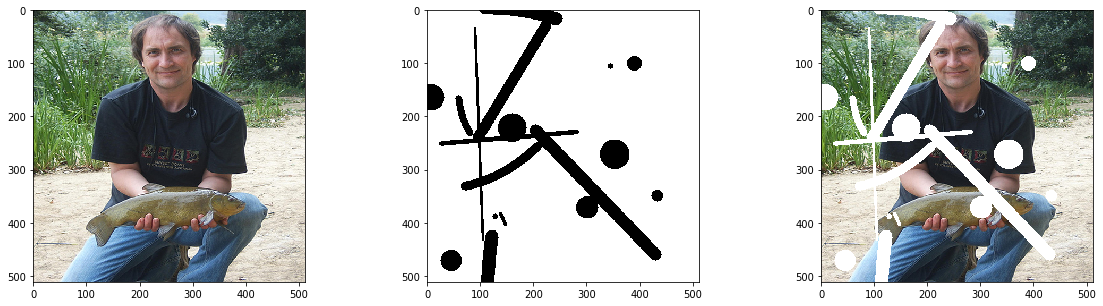

In [10]:
## Testing the model on a single image
# Instantiate mask generator
mask_generator = MaskGenerator(512, 512, 3, rand_seed=42)

# Load image
img = np.array(Image.open(TRAIN_DIR + '/n01440764/n01440764_1775.JPEG').resize((512, 512))) / 255

# Load mask
mask = mask_generator.sample()

# Image + mask
masked_img = copy.deepcopy(img)
masked_img[mask==0] = 1

# Show side by side
_, axes = plt.subplots(1, 3, figsize=(20, 5))
axes[0].imshow(img)
axes[1].imshow(mask*255)
axes[2].imshow(masked_img)
plt.show()

In [11]:
# Creating data generator
def plot_sample_data(masked, mask, ori, middle_title='Raw Mask'):
    _, axes = plt.subplots(1, 3, figsize=(20, 5))
    axes[0].imshow(masked[:,:,:])
    axes[0].set_title('Masked Input')
    axes[1].imshow(mask[:,:,:])
    axes[1].set_title(middle_title)
    axes[2].imshow(ori[:,:,:])
    axes[2].set_title('Target Output')
    plt.show()

class DataGenerator(ImageDataGenerator):
    def flow(self, x, *args, **kwargs):
        while True:
            
            # Get augmentend image samples
            ori = next(super().flow(x, *args, **kwargs))

            # Get masks for each image sample
            mask = np.stack([mask_generator.sample() for _ in range(ori.shape[0])], axis=0)

            # Apply masks to all image sample
            masked = copy.deepcopy(ori)
            masked[mask==0] = 1

            # Yield ([ori, masl],  ori) training batches
            # print(masked.shape, ori.shape)
            gc.collect()
            yield [masked, mask], ori        

# Create datagen
datagen = DataGenerator(  
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

# Create generator from numpy array
batch = np.stack([img for _ in range(BATCH_SIZE)], axis=0)
generator = datagen.flow(x=batch, batch_size=BATCH_SIZE)

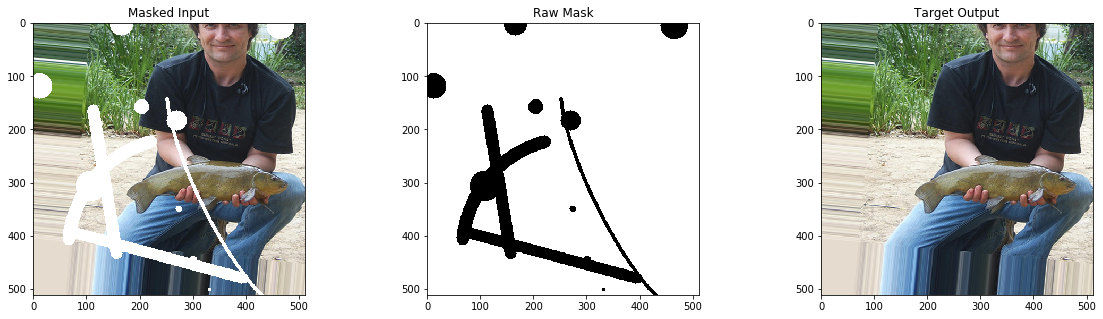

In [12]:
[m1, m2], o1 = next(generator)
plot_sample_data(m1[0], m2[0]*255, o1[0])

In [14]:
## Training the inpainting UNet on single image
# Instantiate model
model = PConvUnet(vgg_weights='./assets/pytorch_to_keras_vgg16.h5')

In [ ]:
model.fit_generator(
    generator, 
    steps_per_epoch=200,
    epochs=5,
    callbacks=[
        TensorBoard(
            log_dir='./data/logs/single_image_test',
            write_graph=False
        ),
        ModelCheckpoint(
            './data/logs/single_image_test/weights.{epoch:02d}-{loss:.2f}.h5',
            monitor='loss', 
            save_best_only=True, 
            save_weights_only=True
        ),
        LambdaCallback(
            on_epoch_end=lambda epoch, logs: plot_sample_data(
                masked_img, 
                model.predict(
                    [
                        np.expand_dims(masked_img,0), 
                        np.expand_dims(mask,0)
                    ]
                )[0]
                , 
                img,
                middle_title='Prediction'
            )
        )
    ],
)

Epoch 1/5
 80/200 [===========>..................] - ETA: 2:23:25 - loss: 9.8219 - PSNR: 11.02 - ETA: 2:04:06 - loss: 9.7465 - PSNR: 10.93 - ETA: 1:57:45 - loss: 9.9516 - PSNR: 10.98 - ETA: 1:54:19 - loss: 9.9949 - PSNR: 11.02 - ETA: 1:51:43 - loss: 9.9558 - PSNR: 10.99 - ETA: 1:50:13 - loss: 9.8996 - PSNR: 10.96 - ETA: 1:49:24 - loss: 9.8187 - PSNR: 10.95 - ETA: 1:48:53 - loss: 9.8181 - PSNR: 10.97 - ETA: 1:48:03 - loss: 9.8185 - PSNR: 10.96 - ETA: 1:47:01 - loss: 9.7957 - PSNR: 10.95 - ETA: 1:46:41 - loss: 9.7743 - PSNR: 10.94 - ETA: 1:45:54 - loss: 9.7258 - PSNR: 10.94 - ETA: 1:45:39 - loss: 9.6990 - PSNR: 10.93 - ETA: 1:45:17 - loss: 9.6898 - PSNR: 10.92 - ETA: 1:44:35 - loss: 9.7004 - PSNR: 10.92 - ETA: 1:44:11 - loss: 9.6827 - PSNR: 10.92 - ETA: 1:43:31 - loss: 9.6918 - PSNR: 10.91 - ETA: 1:43:27 - loss: 9.6892 - PSNR: 10.91 - ETA: 1:42:43 - loss: 9.6581 - PSNR: 10.91 - ETA: 1:41:48 - loss: 9.6728 - PSNR: 10.91 - ETA: 1:40:54 - loss: 9.6297 - PSNR: 10.91 - ETA: 1:40:14 - loss: 9.